In [1]:
%matplotlib inline
import csv
import os
import glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
def find_peak_index(row):
    peak_index = np.argmax(row)
    return peak_index

def find_peak_frequency(freq_values, peak_index):
    peak_frequency = freq_values[peak_index]
    return peak_frequency

def find_complex_peak_index(row):
    magnitudes = np.abs(row)
    peak_index = np.argmax(magnitudes)
    return peak_index

def calculate_phase_angles(xy, peak_indices):
    phase_angles_degrees = []
    for i, peak_index in enumerate(peak_indices):
        complex_value = xy[i][peak_index]
        phase_angle_radians = np.angle(complex_value)
        phase_angle_degrees = np.degrees(phase_angle_radians)
        phase_angles_degrees.append(phase_angle_degrees)
    return phase_angles_degrees

def datetime_to_mjd(t):
    mjd_epoch=np.datetime64('1858-11-17T00:00:00')
    time_differences = t - mjd_epoch
    mjd_values = time_differences / np.timedelta64(1, 'D')
    return mjd_values

def find_peak_frequencies(xy, frequency_values):
    magnitudes = np.abs(xy)    
    peak_frequency_indices = np.argmax(magnitudes, axis=1)
    peak_frequencies = frequency_values[peak_frequency_indices]
    return peak_frequencies

In [3]:
# plot variables
mark_size = 0.5

# gnuradio settings
nfft = 4096
samp_rate = 1e6
decim1 = 16
integ = 10

integrate = int(samp_rate/decim1/nfft*integ)
print(integrate) # print this to double check :-)

#observation details
object_observed = "GOES 18 [51850, 2022-021A]"
frequency = "2211.056"
site = 8049

directory_path = '/home/scott/blade_test/'

filename_pattern = '*.xx.f32'

latest_file = max(glob.glob(os.path.join(directory_path, filename_pattern)), key=os.path.getctime)

filename_parts = os.path.basename(latest_file).split('.')[0].split('_')
date_str = filename_parts[0]  # Format: yyyy-mm-ddThh:mm:ss

date_format = "%Y-%m-%dT%H:%M:%S"
datetime_obj = datetime.strptime(date_str, date_format)
formatted_datetime = datetime_obj.strftime("%Y-%m-%dT%H:%M:%S")

xx = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.xx.f32'), dtype='float32').reshape((-1, nfft))
yy = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.yy.f32'), dtype='float32').reshape((-1, nfft))
xy = np.fromfile(os.path.join(directory_path, f'{formatted_datetime}.xy.c64'), dtype='complex64').reshape((-1, nfft))

t = np.arange(xx.shape[0]) * integrate * nfft * decim1 / samp_rate * 1e3 * np.timedelta64(1, 'ms') + np.datetime64(datetime_obj)
print("Latest Filename:", latest_file)
print("Datetime:", datetime_obj)

frequency_values = np.arange((samp_rate/decim1)/-2.0, (samp_rate/decim1)/2.0, (samp_rate/decim1)/nfft)
frequency_values += float(frequency) *1e6

152
Latest Filename: /home/scott/blade_test/2023-10-13T06:51:36.xx.f32
Datetime: 2023-10-13 06:51:36


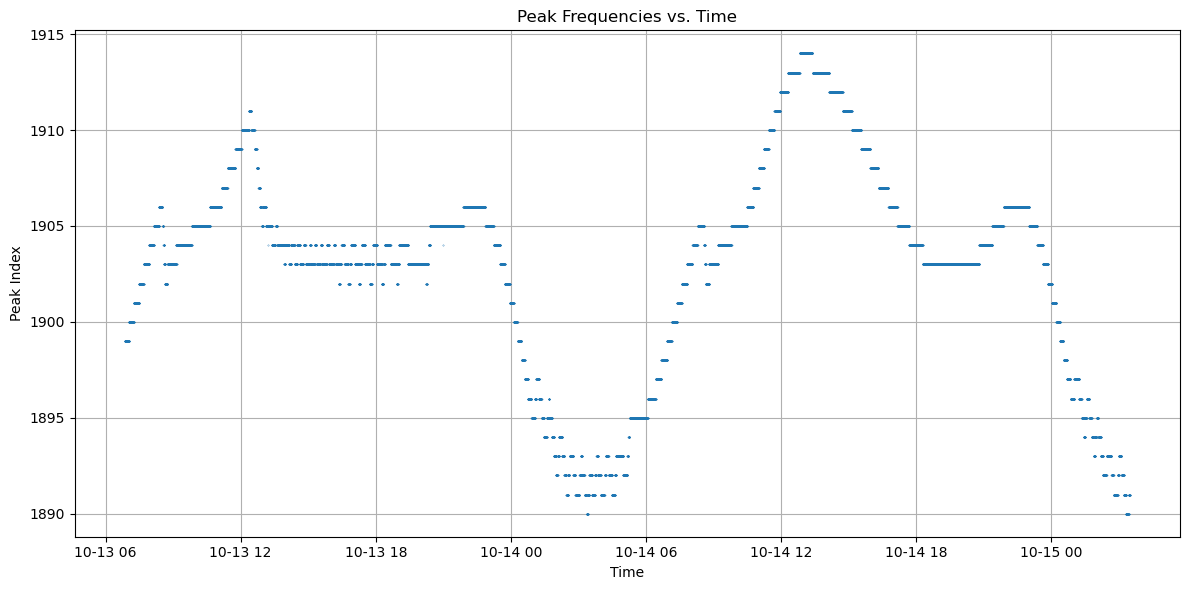

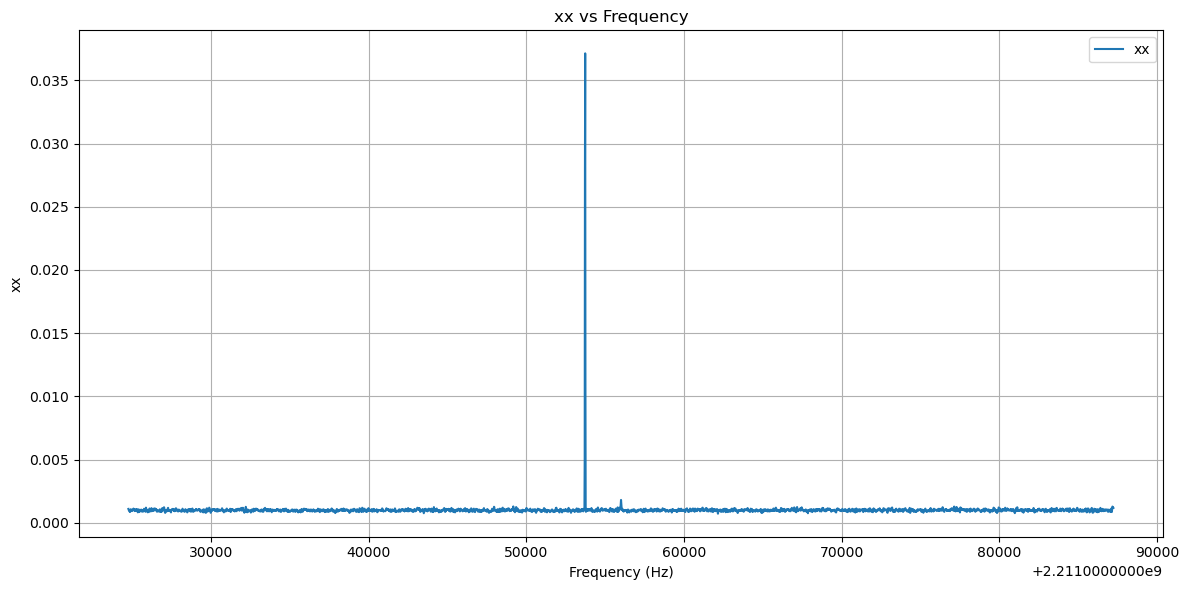

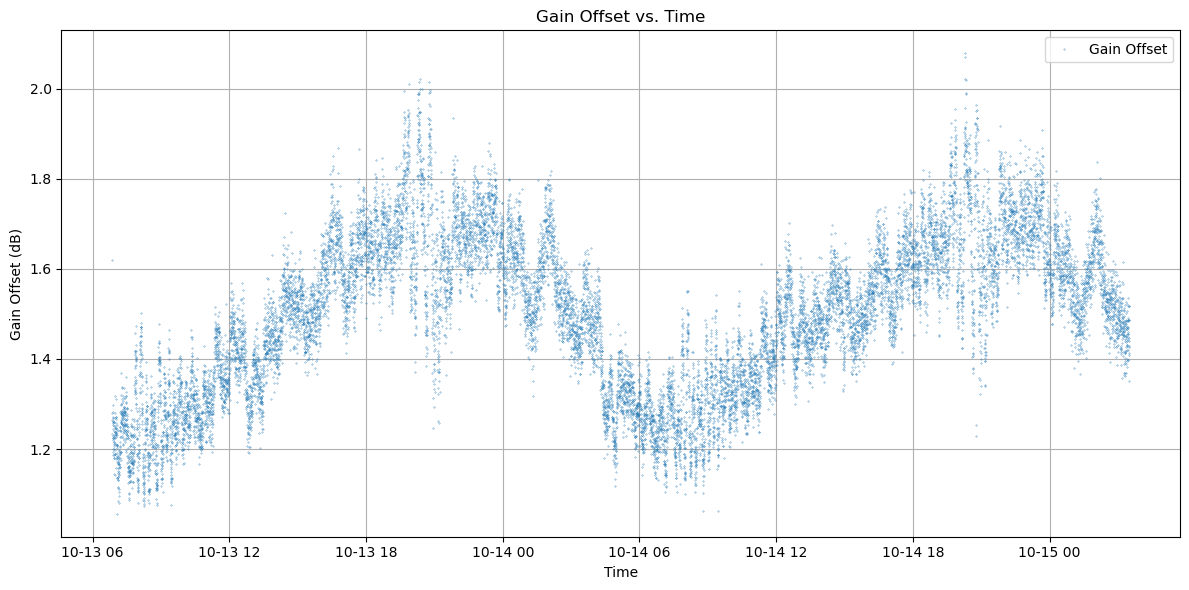

In [4]:
# Gain Calibration

peak_index = [find_peak_index(row) for row in xx]

gain_offset = [xx[i][index] / yy[i][index] for i, index in enumerate(peak_index)]
gain_offset = np.array(gain_offset)[:, np.newaxis]

yy *= gain_offset
xy *= np.sqrt(gain_offset)

plt.figure(figsize=(12, 6))
plt.plot(t, peak_index, '.', markersize=mark_size)
plt.title('Peak Frequencies vs. Time')
plt.xlabel('Time')
plt.ylabel('Peak Index')
plt.grid(True)
plt.tight_layout()

filename = f'{object_observed}_{formatted_datetime}_gain_peak_f.png'
plt.savefig(filename)


plt.figure(figsize=(12, 6))
plt.plot(frequency_values, xx[0, :], label='xx', markersize=mark_size)
plt.title('xx vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('xx')
plt.grid(True)
plt.legend()
plt.tight_layout()
filename = f'{object_observed}_{formatted_datetime}_xx_freq.png'
plt.savefig(filename)

plt.figure(figsize=(12, 6))
plt.plot(t, gain_offset, '.', label='Gain Offset', markersize=mark_size)
plt.title('Gain Offset vs. Time')
plt.xlabel('Time')
plt.ylabel('Gain Offset (dB)')
plt.grid(True)
plt.legend()
plt.tight_layout()
filename = f'{object_observed}_{formatted_datetime}_gain_offset.png'
plt.savefig(filename)

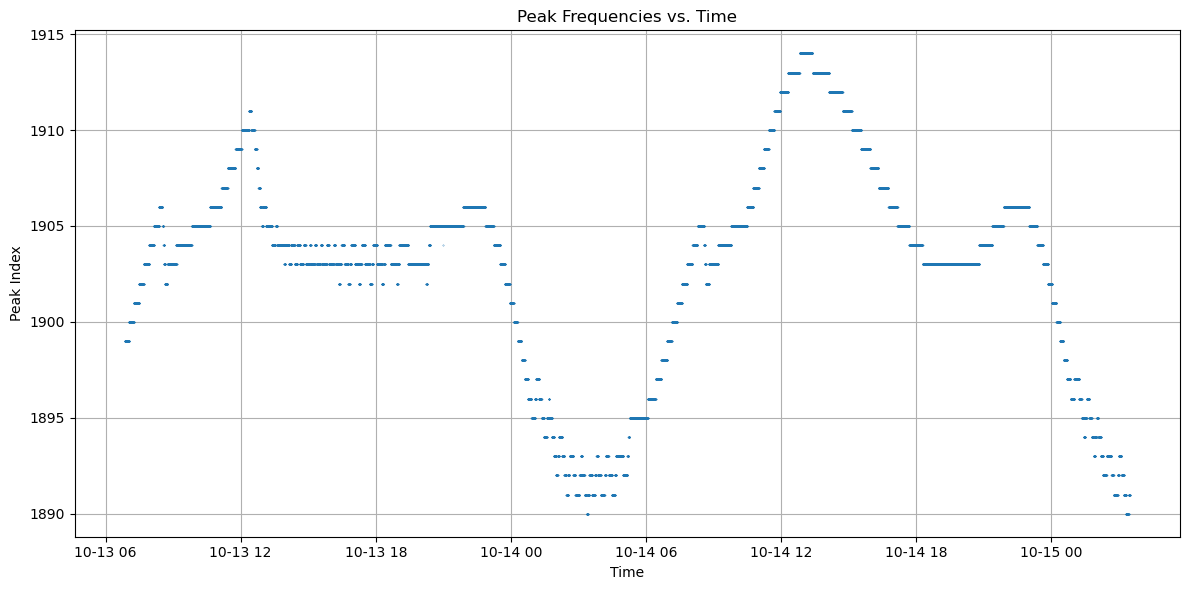

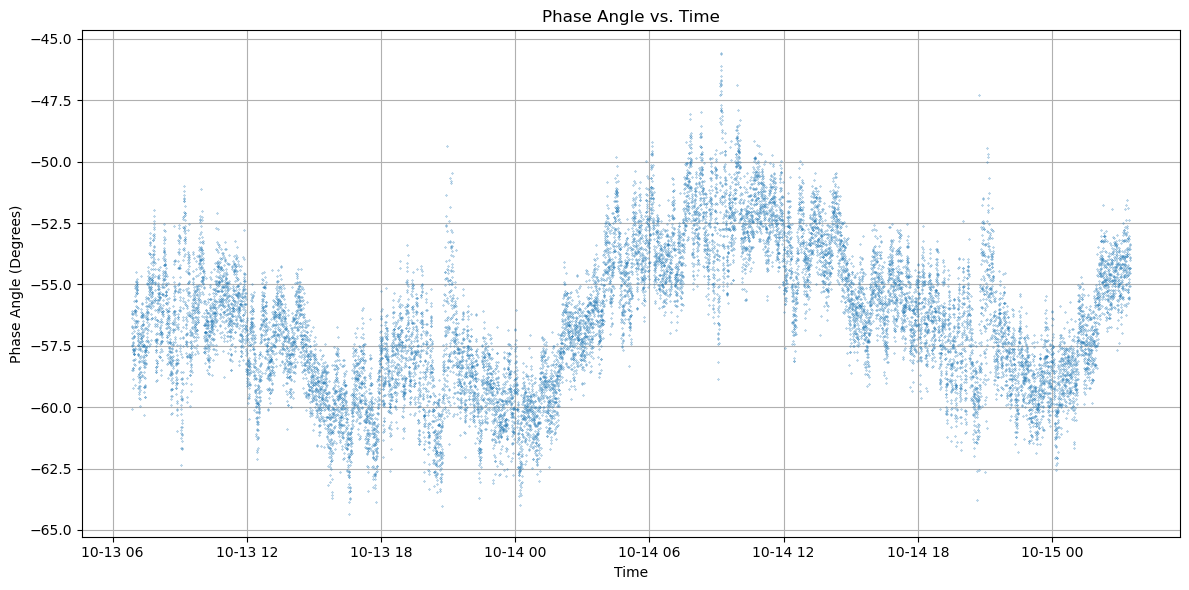

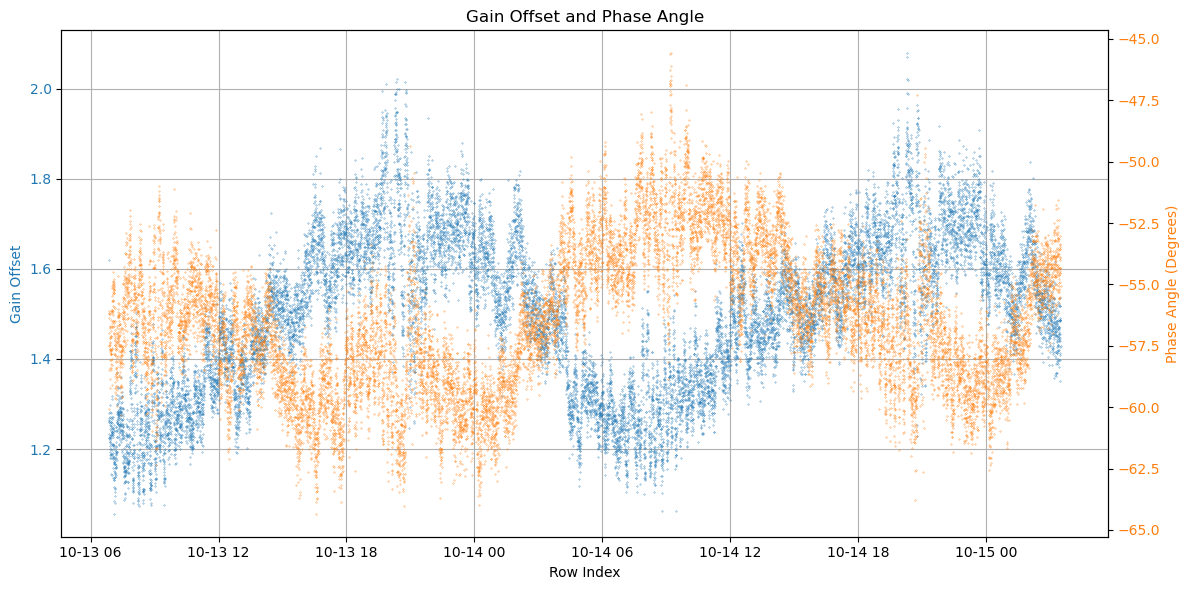

In [5]:
# Phase calibration

peak_index_xy = [find_complex_peak_index(row) for row in xy]

phase_angles_degrees = calculate_phase_angles(xy, peak_index_xy)

for i in range(len(xy)):
    xy[i] *= np.exp(-1j * np.deg2rad(phase_angles_degrees[i])) * (-1j)


plt.figure(figsize=(12, 6))
plt.plot(t, peak_index_xy, '.', markersize=mark_size)
plt.title('Peak Frequencies vs. Time')
plt.xlabel('Time')
plt.ylabel('Peak Index')
plt.grid(True)
plt.tight_layout()

filename = f'{object_observed}_{formatted_datetime}_peak_f_xy.png'
plt.savefig(filename)


plt.figure(figsize=(12, 6))
plt.plot(t, phase_angles_degrees, '.', markersize=mark_size)
plt.title('Phase Angle vs. Time')
plt.xlabel('Time')
plt.ylabel('Phase Angle (Degrees)')
plt.grid(True)
plt.tight_layout()


fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Row Index')
ax1.set_ylabel('Gain Offset', color=color)
plt.grid(True)
plt.tight_layout()
ax1.plot(t, gain_offset, '.', markersize=mark_size, label='Gain Offset', color=color)
ax1.tick_params(axis='y', labelcolor=color)
filename = f'{object_observed}_{formatted_datetime}_phase_angle.png'
plt.savefig(filename)



ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Phase Angle (Degrees)', color=color)
ax2.plot(t,phase_angles_degrees, '.', markersize=mark_size, label='Phase Angle (Degrees)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Gain Offset and Phase Angle')
fig.tight_layout()



filename = f'{object_observed}_{formatted_datetime}_gain_phase.png'
plt.savefig(filename)



In [6]:
signal_peak = np.argmax(xx + yy, axis = 1)
offsets = np.arange(-2,3)
signal_xx = np.zeros(xx.shape[0])
signal_yy = np.zeros(yy.shape[0])
signal_xy = np.zeros(xy.shape[0], dtype = 'complex')
for offset in np.arange(-2,3):
    signal_xx += xx[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_yy += yy[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_xy += xy[np.arange(signal_peak.shape[0]), signal_peak + offset]
signal_xx /= offsets.size
signal_yy /= offsets.size
signal_xy /= offsets.size
gain_xx_yy = np.median(signal_xx + signal_yy)
signal_xx /= gain_xx_yy
signal_yy /= gain_xx_yy
signal_xy /= gain_xx_yy

In [7]:
I = signal_xx + signal_yy
Q = signal_xx - signal_yy
U = 2*signal_xy.real
V = -2*signal_xy.imag
L = Q + 1j*U
P = np.sqrt(Q**2 + U**2 + V**2)

2023-10-13T06:51:36.dat


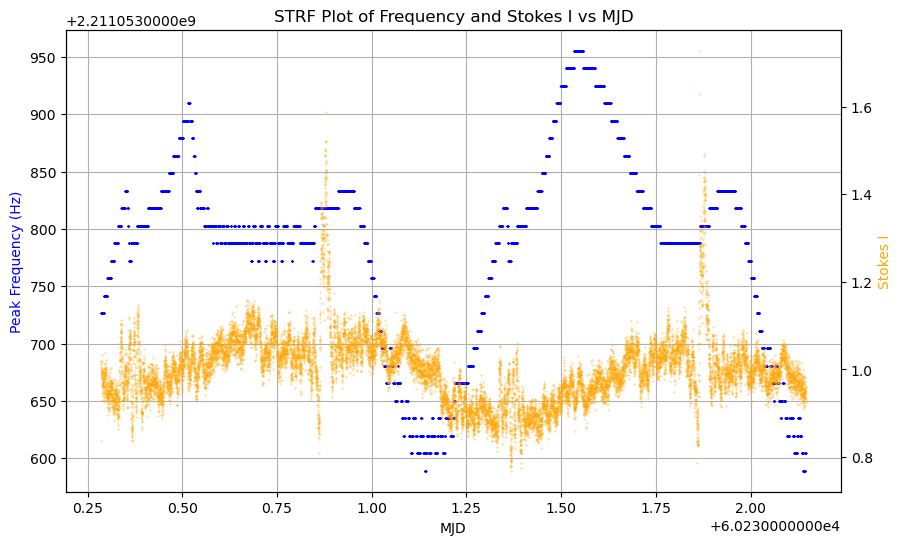

In [8]:
# STRF output in MJD,Peak_Frequency,Stokes I(dB),obs_site
n_rows = xy.shape[0]  # Replace 'xy' with your actual array
site_array = np.full((n_rows,), site)
rows = zip(datetime_to_mjd(t), find_peak_frequencies(xy,frequency_values), I, site_array)

output_file = f'{formatted_datetime}.dat'
print(output_file)

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t') 
    writer.writerows(rows)

plt.figure(figsize=(10, 6))
ax1 = plt.subplot(111)
ax2 = ax1.twinx()  # Create a new y-axis on the right
ax1.plot(datetime_to_mjd(t), find_peak_frequencies(xy,frequency_values), '.', markersize=mark_size, color='blue')
ax1.set_xlabel('MJD')
ax1.set_ylabel('Peak Frequency (Hz)', color='blue')
ax1.grid(True)
ax2.plot(datetime_to_mjd(t), I, '.', markersize=mark_size, color='orange')
ax2.set_ylabel('Stokes I', color='orange')
plt.title('STRF Plot of Frequency and Stokes I vs MJD')

filename = f'{object_observed}_{formatted_datetime}_STRF.png'
plt.savefig(filename)

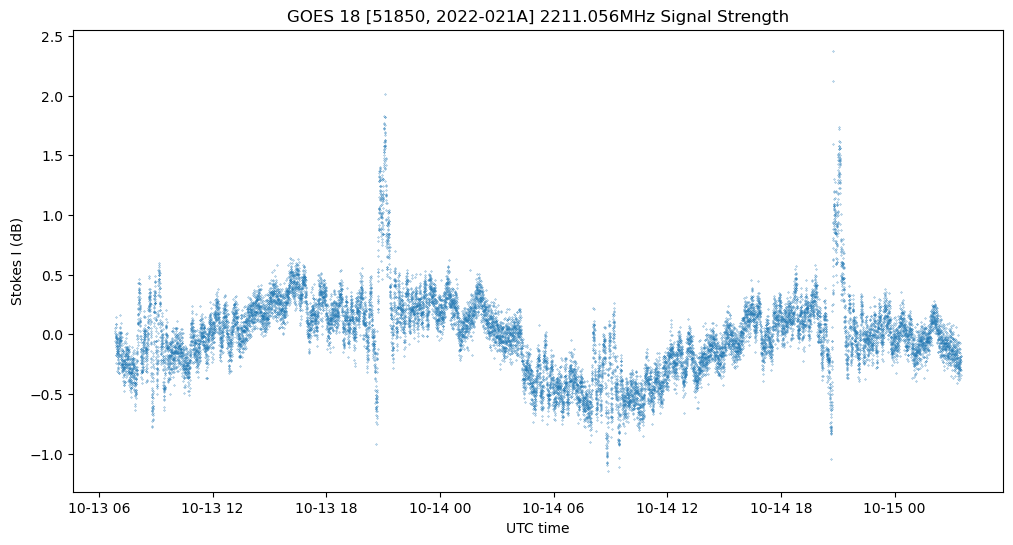

In [9]:
sel = slice(1,None)
plt.figure(figsize = (12, 6))
plt.plot(t[sel], 10*np.log10(I[sel]), '.', markersize=mark_size)
plt.ylabel('Stokes I (dB)')
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Signal Strength'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_sig_strength.png'
plt.savefig(filename)

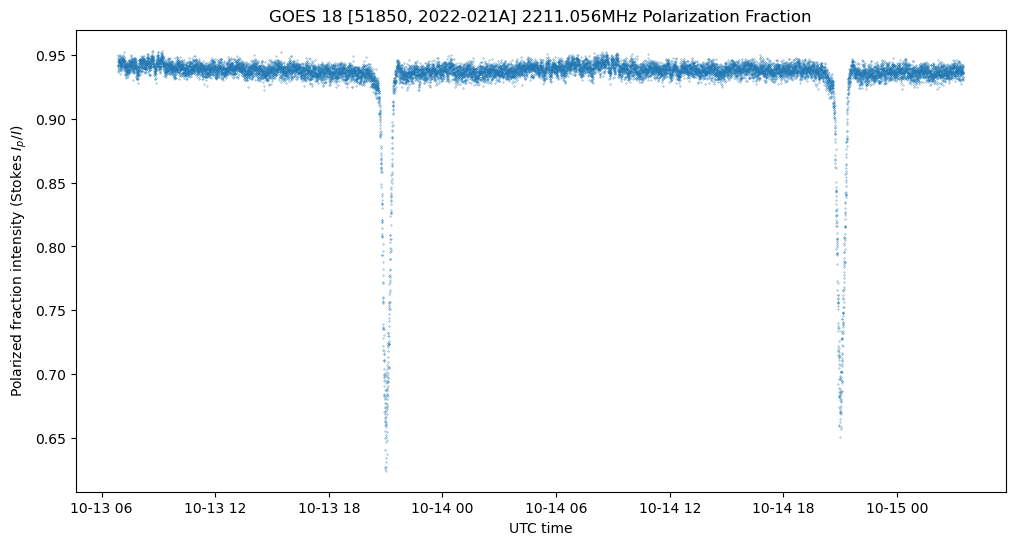

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (P/I)[sel], '.', markersize=mark_size)
plt.xlabel('UTC time')
plt.ylabel('Polarized fraction intensity (Stokes $I_p/I$)')
title_text = f'{object_observed} {frequency}MHz Polarization Fraction'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_pol_frac.png'
plt.savefig(filename)

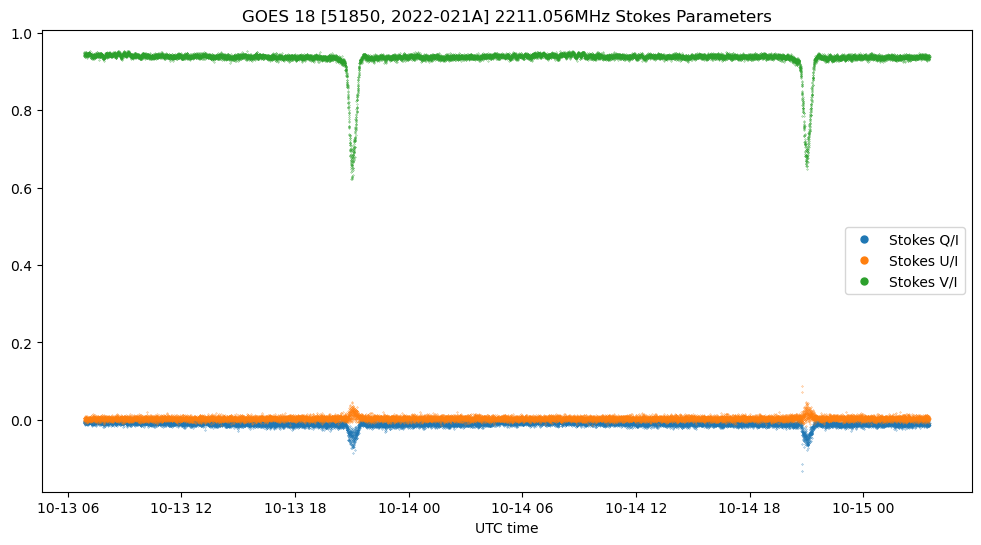

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(t[sel], (Q/I)[sel], '.', markersize=mark_size)
plt.plot(t[sel], (U/I)[sel], '.', markersize=mark_size)
plt.plot(t[sel], (V/I)[sel], '.', markersize=mark_size)
legend = plt.legend(['Stokes Q/I', 'Stokes U/I', 'Stokes V/I'])
for handle in legend.legendHandles:
    handle.set_markersize(10)  # Adjust the marker size as needed
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes Parameters'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_stokes_par.png'
plt.savefig(filename)

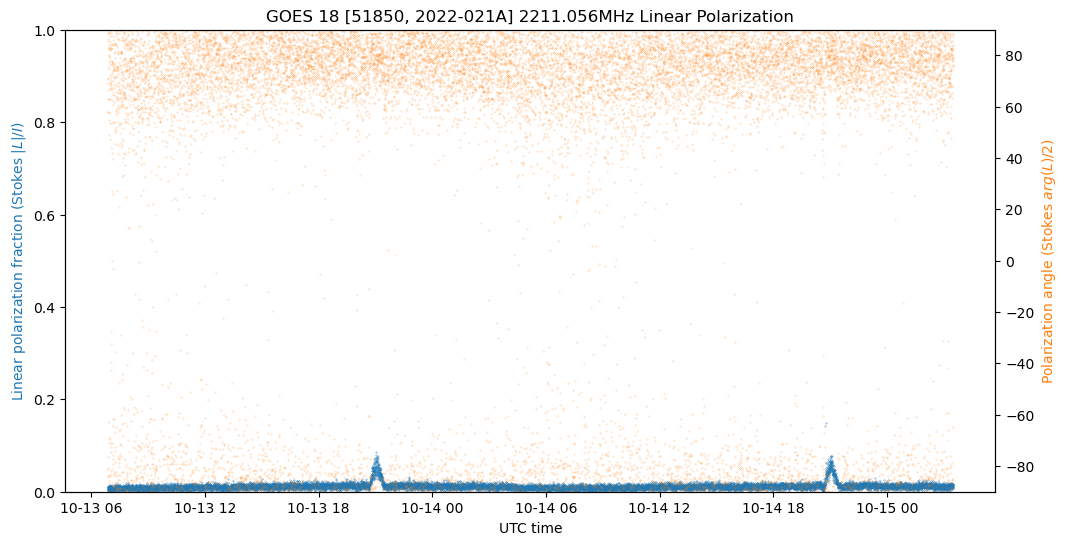

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(t[sel], (np.abs(L) / I)[sel], '.', alpha=1, markersize=mark_size)
plt.ylim((0, 1))
plt.xlabel('UTC time')
plt.ylabel('Linear polarization fraction (Stokes $|L|/I$)', color='C0')
ax2 = plt.gca().twinx()
plt.plot(t[sel], np.rad2deg(np.angle(L[sel]) / 2), '.', color='C1', alpha=0.5, markersize=mark_size)
ax2.set_ylabel('Polarization angle (Stokes $arg(L)/2$)', color='C1')
ax2.set_ylim((-90, 90))
title_text = f'{object_observed} {frequency}MHz Linear Polarization'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_lin_pol.png'
plt.savefig(filename)

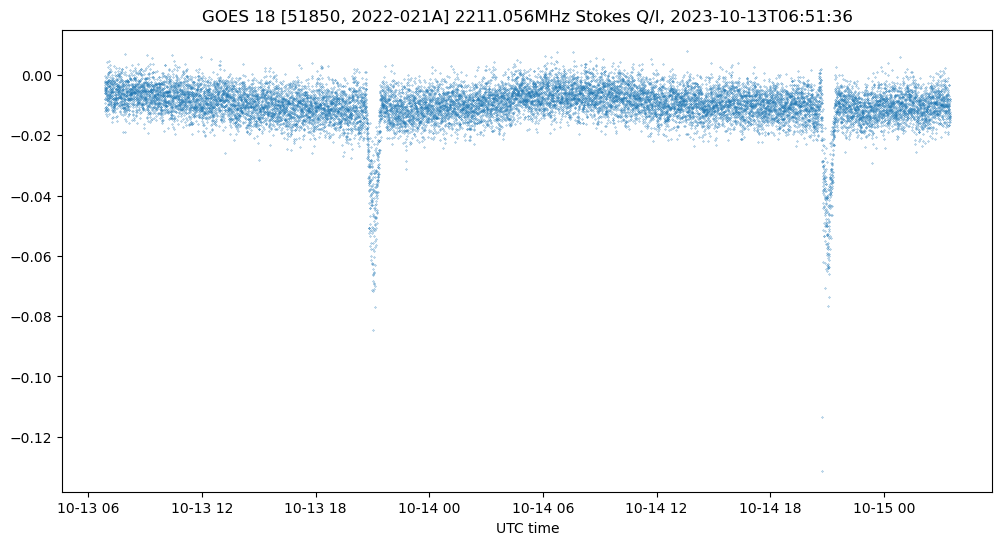

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (Q/I)[sel], '.', markersize=mark_size)
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes Q/I, {formatted_datetime}'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_stokes_Q_I.png'
plt.savefig(filename)

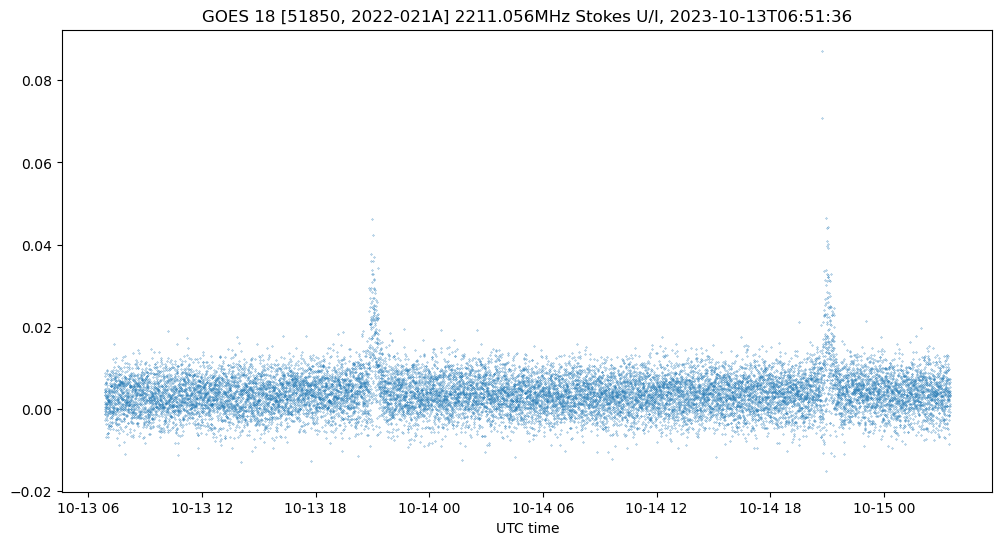

In [14]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (U/I)[sel], '.', markersize=mark_size)
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes U/I, {formatted_datetime}'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_stokes_U_I.png'
plt.savefig(filename)

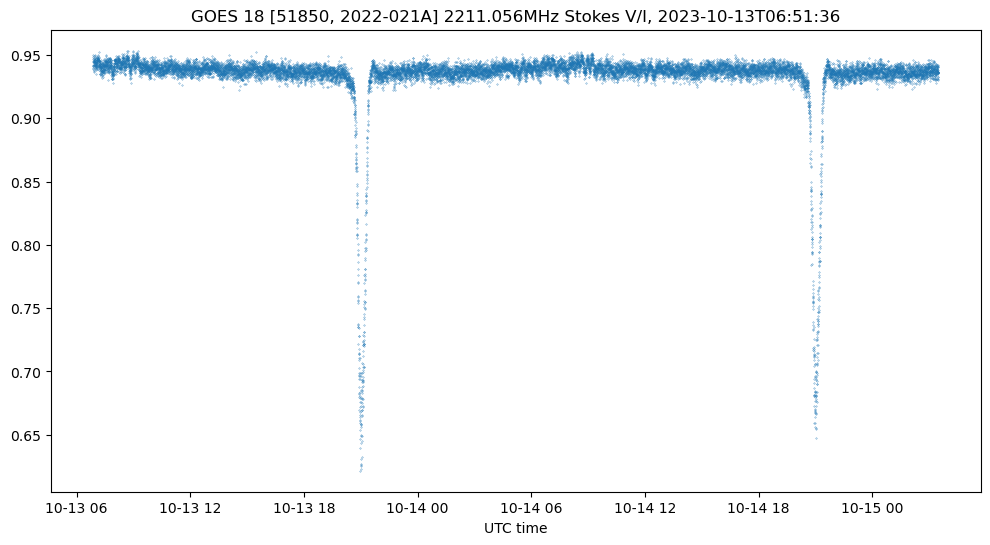

In [15]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (V/I)[sel], '.', markersize=mark_size)
plt.xlabel('UTC time')
title_text = f'{object_observed} {frequency}MHz Stokes V/I, {formatted_datetime}'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_stokes_V_I.png'
plt.savefig(filename)

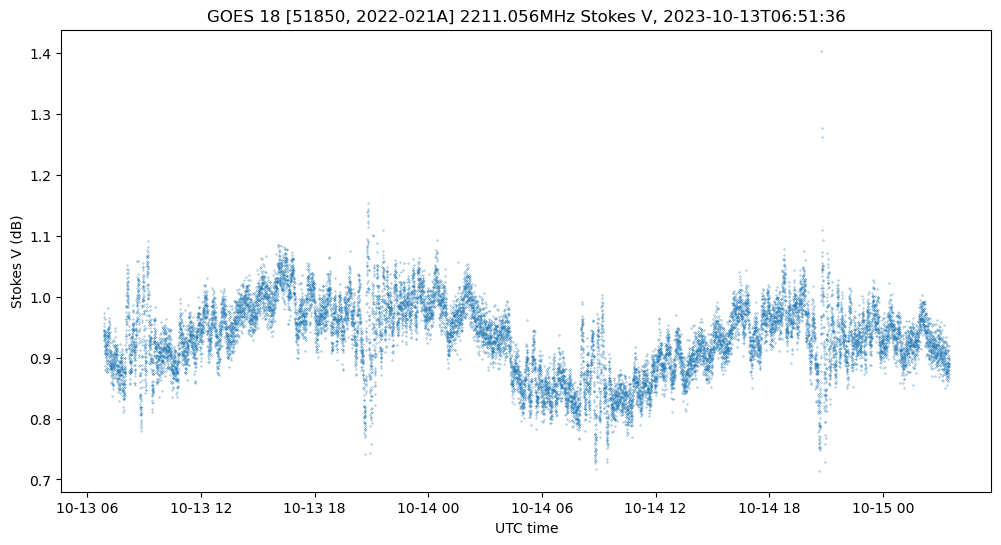

In [16]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (V)[sel], '.', markersize=mark_size)
plt.xlabel('UTC time')
plt.ylabel('Stokes V (dB)')
title_text = f'{object_observed} {frequency}MHz Stokes V, {formatted_datetime}'
plt.title(title_text)

filename = f'{object_observed}_{formatted_datetime}_stokes_V.png'
plt.savefig(filename)

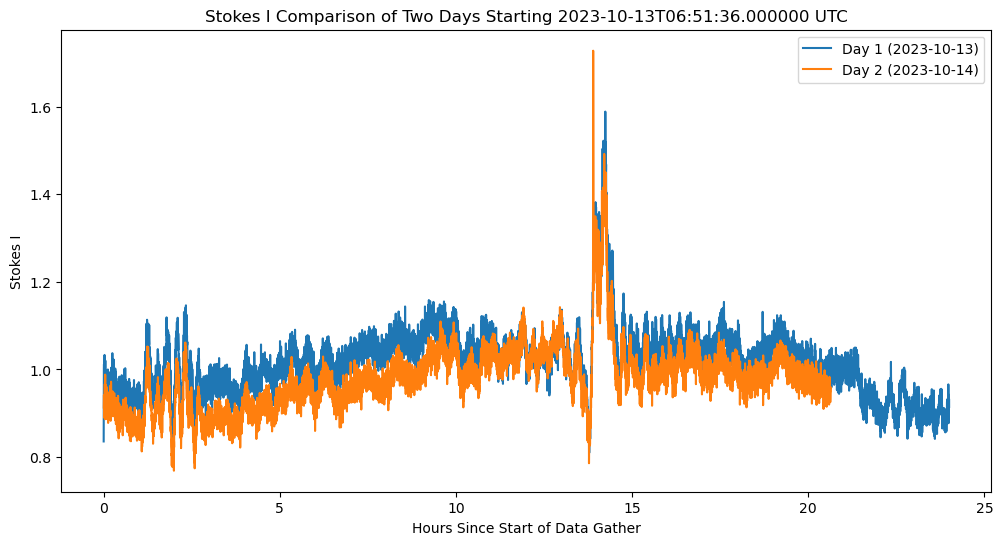

In [17]:
time_diff_ms = (t - t[0]) / np.timedelta64(1, 'ms')

# Calculate the unique day indices
unique_day_indices = np.unique(time_diff_ms // (24 * 60 * 60 * 1000))

# Create a dictionary to store daily data
daily_data = {}
for i, day_index in enumerate(unique_day_indices):
    mask = (time_diff_ms // (24 * 60 * 60 * 1000) == day_index)
    daily_data[i] = (t[mask], I[mask])

# Sort the daily data by day index to ensure correct order
daily_data = dict(sorted(daily_data.items()))

day_start1 = np.min(t)
day_start2 = day_start1 + np.timedelta64(1, 'D')

day1_indices = (t >= day_start1) & (t < day_start2)
day2_indices = (t >= day_start2)

time_hrs1 = (t[day1_indices] - day_start1) / np.timedelta64(1, 'h')
time_hrs2 = (t[day2_indices] - day_start2) / np.timedelta64(1, 'h')

plt.figure(figsize=(12, 6))
plt.plot(time_hrs1, I[day1_indices], label=f'Day 1 ({day_start1.astype("M8[D]").astype(str)})', markersize=mark_size)
plt.plot(time_hrs2, I[day2_indices], label=f'Day 2 ({day_start2.astype("M8[D]").astype(str)})', markersize=mark_size)
plt.xlabel('Hours Since Start of Data Gather')
plt.ylabel('Stokes I')
plt.title(f'Stokes I Comparison of Two Days Starting {np.min(t):} UTC')
plt.legend()

filename = f'{object_observed}_{formatted_datetime}_stokes_I_compare.png'
plt.savefig(filename)

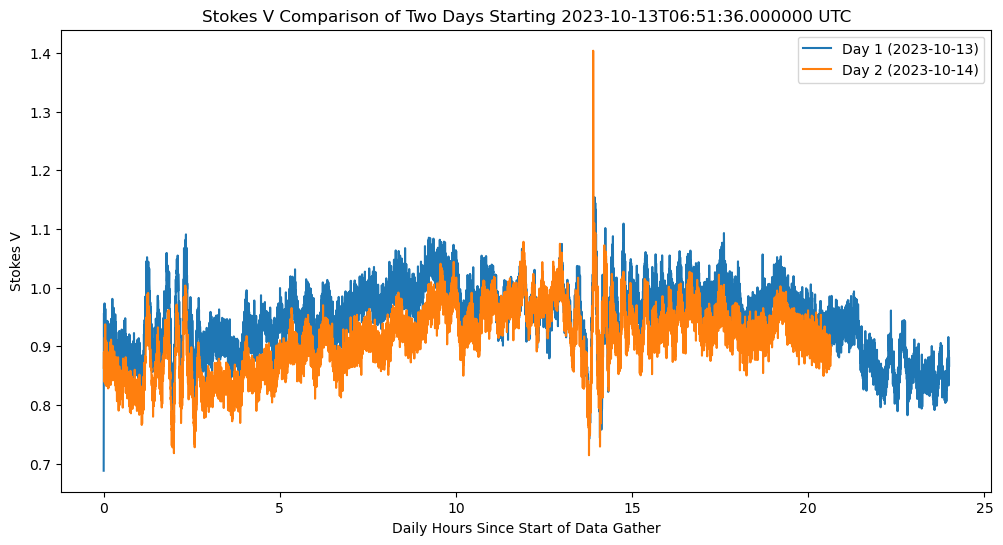

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(time_hrs1, V[day1_indices], label=f'Day 1 ({day_start1.astype("M8[D]").astype(str)})', markersize=mark_size)
plt.plot(time_hrs2, V[day2_indices], label=f'Day 2 ({day_start2.astype("M8[D]").astype(str)})', markersize=mark_size)
plt.xlabel('Daily Hours Since Start of Data Gather')
plt.ylabel('Stokes V')
plt.title(f'Stokes V Comparison of Two Days Starting {np.min(t):} UTC')
plt.legend()

filename = f'{object_observed}_{formatted_datetime}_stokes_V_compare.png'
plt.savefig(filename)

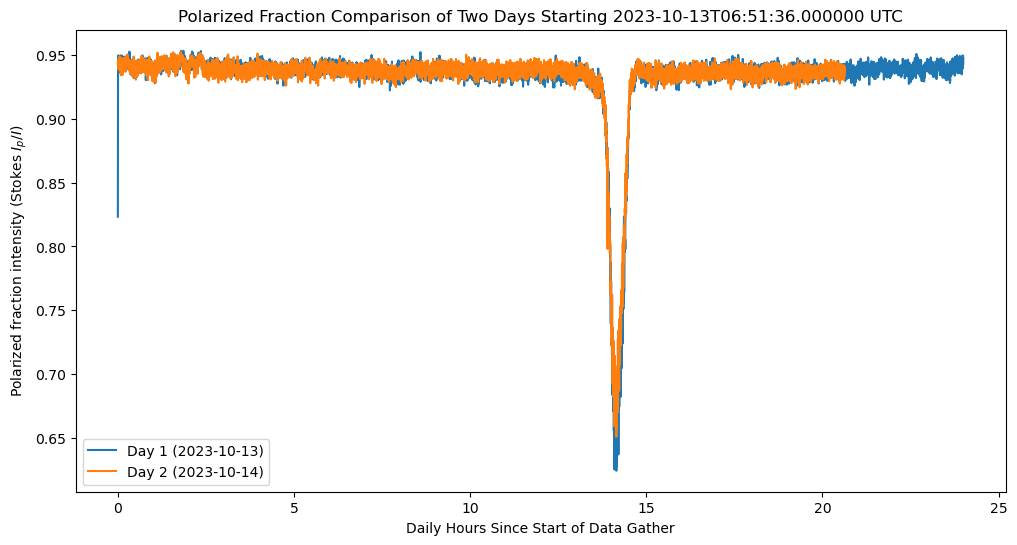

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(time_hrs1, (P/I)[day1_indices], label=f'Day 1 ({day_start1.astype("M8[D]").astype(str)})', markersize=mark_size)
plt.plot(time_hrs2, (P/I)[day2_indices], label=f'Day 2 ({day_start2.astype("M8[D]").astype(str)})', markersize=mark_size)
plt.xlabel('Daily Hours Since Start of Data Gather')
plt.ylabel('Polarized fraction intensity (Stokes $I_p/I$)')
plt.title(f'Polarized Fraction Comparison of Two Days Starting {np.min(t):} UTC')
plt.legend()

filename = f'{object_observed}_{formatted_datetime}_pol_frac_compare.png'
plt.savefig(filename)

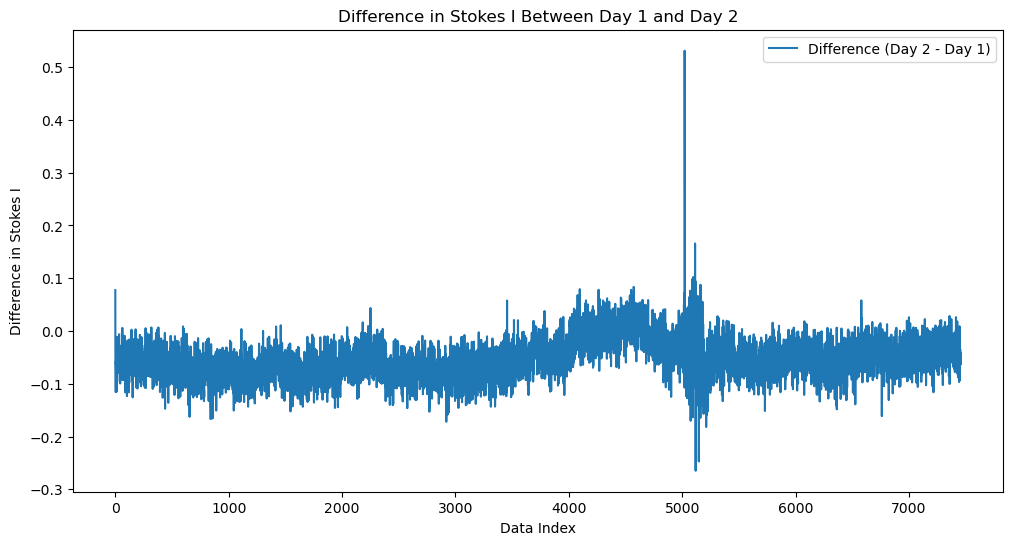

In [20]:
import numpy as np

# Calculate the time relative to the start of each day
day_start1 = np.min(t)
day_start2 = day_start1 + np.timedelta64(1, 'D')

day1_indices = (t >= day_start1) & (t < day_start2)
day2_indices = (t >= day_start2)

# Calculate the lengths of the I arrays for Day 1 and Day 2
length_day1 = np.sum(day1_indices)
length_day2 = np.sum(day2_indices)

# Determine the length of the shortest data array
min_length = min(length_day1, length_day2)

# Create new data arrays for Day 1 and Day 2 with the length of the shortest array
I_day1 = I[day1_indices][:min_length]
I_day2 = I[day2_indices][:min_length]

# Calculate the difference between the data for Day 1 and Day 2
I_difference = I_day2 - I_day1

plt.figure(figsize=(12, 6))
plt.plot(I_difference, label='Difference (Day 2 - Day 1)', markersize=mark_size)
plt.xlabel('Data Index')
plt.ylabel('Difference in Stokes I')
plt.title('Difference in Stokes I Between Day 1 and Day 2')
plt.legend()

filename = f'{object_observed}_{formatted_datetime}_Stokes_I_diff.png'
plt.savefig(filename)